LSTM 기반의 온실내 온도 예측

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [8]:
raw_df = pd.read_csv('./climate_data.csv')  # 온실 환경 데이터
raw_df.head()

,seq_no,inside_temp,Outside_temp,outside_RH,Radiation_intensity,Rail_Heating,AHU_Cooling,Fan_speed,inlet_vent_position
0,1,19.8,24.1,100,0.0,0.0,-3.50,440.0,0.0
1,2,19.7,24.2,100,0.0,0.0,-3.50,294.3,0.0
2,3,19.6,24.1,100,0.0,0.0,-3.50,283.3,0.0
3,4,19.6,24.2,100,0.0,0.0,-3.25,272.3,0.0
4,5,19.5,24.0,100,0.0,0.0,-3.75,261.3,0.0


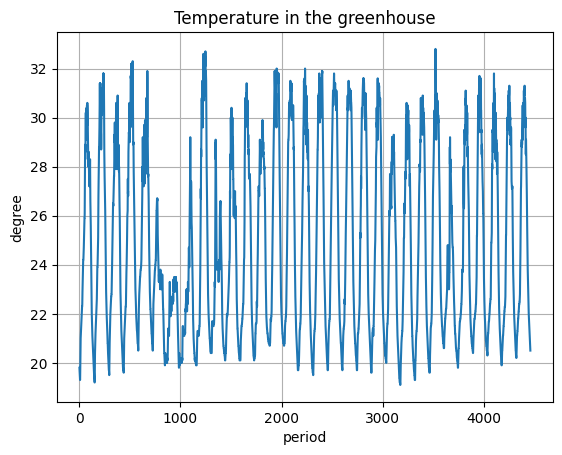

In [9]:
plt.title('Temperature in the greenhouse')
plt.ylabel('degree')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['inside_temp'], label='inside_temp')

plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [10]:
# 통계정보 확인

raw_df.describe()

,seq_no,inside_temp,Outside_temp,outside_RH,Radiation_intensity,Rail_Heating,AHU_Cooling,Fan_speed,inlet_vent_position
count,4464.00000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000
mean,2232.50000,24.809588,27.679570,88.036066,197.308065,0.639897,-3.506272,603.093884,34.867204
std,1288.79013,3.825128,2.585785,10.657682,278.098372,1.400272,2.570764,242.322319,44.631006
min,1.00000,19.100000,21.900000,52.000000,0.000000,-0.250000,-9.250000,0.000000,0.000000
25%,1116.75000,21.400000,26.000000,82.000000,0.000000,0.000000,-5.250000,349.300000,0.000000
50%,2232.50000,23.700000,27.300000,91.000000,32.750000,0.000000,-3.750000,682.000000,0.000000
75%,3348.25000,28.500000,29.300000,97.000000,334.150000,0.000000,-1.500000,879.800000,95.125000
max,4464.00000,32.800000,35.800000,100.000000,1033.600000,10.750000,0.250000,880.800000,100.000000


In [11]:
# Missing Data 확인

raw_df.isnull().sum()

seq_no                 0
inside_temp            0
Outside_temp           0
outside_RH             0
Radiation_intensity    0
Rail_Heating           0
AHU_Cooling            0
Fan_speed              0
inlet_vent_position    0
dtype: int64

In [12]:
# 최소값이 0 인 column 체크

for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Radiation_intensity <class 'str'>
Fan_speed <class 'str'>
inlet_vent_position <class 'str'>


In [13]:
# missing data 확인

raw_df.isnull().sum()

seq_no                 0
inside_temp            0
Outside_temp           0
outside_RH             0
Radiation_intensity    0
Rail_Heating           0
AHU_Cooling            0
Fan_speed              0
inlet_vent_position    0
dtype: int64

In [14]:
raw_df.isnull().any()

seq_no                 False
inside_temp            False
Outside_temp           False
outside_RH             False
Radiation_intensity    False
Rail_Heating           False
AHU_Cooling            False
Fan_speed              False
inlet_vent_position    False
dtype: bool

In [42]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['inside_temp', 'Outside_temp', 'outside_RH', 'Radiation_intensity', 'Rail_Heating',
              'AHU_Cooling', 'Fan_speed', 'inlet_vent_position']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

      inside_temp  Outside_temp  outside_RH  Radiation_intensity  \
0        0.051095      0.158273    1.000000                  0.0   
1        0.043796      0.165468    1.000000                  0.0   
2        0.036496      0.158273    1.000000                  0.0   
3        0.036496      0.165468    1.000000                  0.0   
4        0.029197      0.151079    1.000000                  0.0   
...           ...           ...         ...                  ...   
4459     0.124088      0.258993    0.916667                  0.0   
4460     0.116788      0.237410    0.916667                  0.0   
4461     0.109489      0.244604    0.916667                  0.0   
4462     0.109489      0.266187    0.875000                  0.0   
4463     0.102190      0.287770    0.854167                  0.0   

      Rail_Heating  AHU_Cooling  Fan_speed  inlet_vent_position  
0         0.022727     0.605263   0.499546                  0.0  
1         0.022727     0.605263   0.334128         

 - 시계열 데이터를 위한 window_size = 7 선정

In [43]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [53]:
# feature_df, label_df 생성

feature_cols = ['Outside_temp', 'outside_RH', 'Radiation_intensity', 'Rail_Heating',
              'AHU_Cooling', 'Fan_speed', 'inlet_vent_position']
label_cols = [ 'inside_temp' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [54]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(4464, 7) (4464, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [61]:
window_size = 7

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(4457, 7, 7) (4457, 1)


학습데이터, 테스트데이터 생성

In [62]:
# train, test 분리

#split = int(len(X)*0.80)
split = -392

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4065, 7, 7) (4065, 1)
(392, 7, 7) (392, 1)


모델 구축 및 컴파일

In [73]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [74]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 50, 50)            10400     
                                                                 
 lstm_15 (LSTM)              (None, 64)                29440     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [75]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100


ValueError: in user code:

    File "C:\Users\bradj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\bradj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bradj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\bradj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\bradj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\bradj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 50, 1), found shape=(None, 7, 7)


예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

13/13 [==============================] - 0s 2ms/step


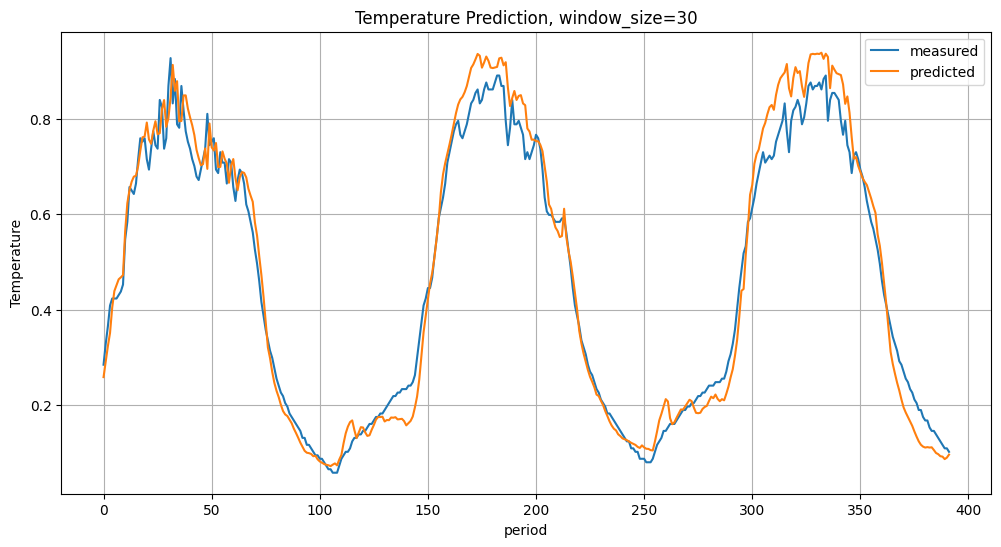

In [66]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('Temperature Prediction, window_size=30')
plt.ylabel('Temperature')
plt.xlabel('period')
plt.plot(y_test, label='measured')
plt.plot(pred, label='predicted')
plt.grid()
plt.legend(loc='best')

plt.show()

In [52]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.040724602222207584
